# Explore latents for Brazil-Malvinis

In [43]:
%matplotlib inline

In [22]:
# imports
from importlib import reload

import os
import numpy as np
import datetime

import pandas
import xarray
import h5py

import umap

from matplotlib import pyplot as plt
import seaborn as sns

from ulmo import io as ulmo_io
from ulmo import plotting
from ulmo.llc import io as llc_io
from ulmo.llc import plotting as llc_plotting

from ulmo.utils import image_utils
from ulmo.analysis import figures as ulmo_figs
from ulmo.models import io as model_io
from ulmo.modis import io as modis_io

# Load em all

In [2]:
tbl_file = 's3://modis-l2/Tables/MODIS_L2_std.parquet' 

In [3]:
modisl2_table = ulmo_io.load_main_table(tbl_file)

Read main table: s3://modis-l2/Tables/MODIS_L2_std.parquet


In [6]:
modisl2_table.head()

,lat,lon,col,datetime,LL,row,clear_fraction,mean_temperature,Tmin,Tmax,T90,T10,filename,UID,pp_file,pp_root,field_size,pp_type,pp_idx
0,13.980967,62.675774,517,2003-03-10 21:25:00,520.178711,304,0.000000,26.199476,25.250000,26.885000,26.474998,25.814999,AQUA_MODIS.20030310T212506.L2.SST.nc,1047103981024267577,s3://modis-l2/PreProc/MODIS_R2019_2003_95clear...,standard,128,0,0
1,13.043748,-102.751816,706,2003-12-12 08:30:00,432.766724,1696,0.049805,28.924648,27.789999,29.654999,29.154999,28.695000,AQUA_MODIS.20031212T083006.L2.SST.nc,107110304377724818,s3://modis-l2/PreProc/MODIS_R2019_2003_95clear...,standard,128,0,1
2,-18.086618,40.844833,581,2003-09-24 22:35:00,764.413086,656,0.006104,25.551611,24.775000,26.154999,25.750000,25.344999,AQUA_MODIS.20030924T223506.L2.SST.nc,106471913422084483,s3://modis-l2/PreProc/MODIS_R2019_2003_95clear...,standard,128,0,2
3,39.071575,18.569141,1028,2003-05-01 01:05:00,371.310120,898,0.049988,16.414951,15.160000,17.205000,16.725000,16.080000,AQUA_MODIS.20030501T010506.L2.SST.nc,1051129071619856914,s3://modis-l2/PreProc/MODIS_R2019_2003_95clear...,standard,128,0,3
4,17.901926,90.155480,997,2003-12-05 19:55:00,-214.759277,1520,0.035461,26.744499,24.975000,28.724998,27.824999,25.830000,AQUA_MODIS.20031205T195506.L2.SST.nc,1070107901927015548,s3://modis-l2/PreProc/MODIS_R2019_2003_95clear...,standard,128,0,4


In [7]:
modisl2_table['DT'] = modisl2_table.T90 - modisl2_table.T10

# Load latents

In [15]:
latents_2019_file = 's3://modis-l2/Evaluations/MODIS_R2019_2019_95clear_128x128_latents_std.h5'

In [16]:
with ulmo_io.open(latents_2019_file, 'rb') as f:
    l_hf = h5py.File(f, 'r')

In [18]:
l_hf = h5py.File(ulmo_io.load_to_bytes(latents_2019_file), 'r')

<ipython-input-18-c42a8f0dad89>:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  l_hf = h5py.File(ulmo_io.load_to_bytes(latents_2019_file))


In [19]:
latents_2019 = l_hf['latents'][:]

In [20]:
latents_2019.shape

(751689, 512)

# Isolate Brazil and $\Delta T \approx 2$K and 2019

## Location and $\Delta T$

In [8]:
# Brazil
in_brazil = ((np.abs(modisl2_table.lon.values + 57.5) < 10.)  & 
    (np.abs(modisl2_table.lat.values + 43.0) < 10))
in_DT = np.abs(modisl2_table.DT - 2.05) < 0.05

## Date

In [12]:
in_2019 = modisl2_table.datetime >= datetime.datetime(2019,1,1)

## Implement

In [13]:
evals_bz = modisl2_table[in_brazil & in_DT & in_2019].copy()

In [14]:
evals_bz.head()

,lat,lon,col,datetime,LL,row,clear_fraction,mean_temperature,Tmin,Tmax,T90,T10,filename,UID,pp_file,pp_root,field_size,pp_type,pp_idx,DT
11607569,-46.332176,-56.542492,997,2019-01-26 05:10:00,-377.866211,272,0.007324,12.108228,10.135,14.775000,13.245,11.219999,AQUA_MODIS.20190126T051001.L2.SST.nc,154843667812345751,s3://modis-l2/PreProc/MODIS_R2019_2019_95clear...,standard,128,0,1209,2.025001
11608156,-44.843760,-58.942886,385,2019-01-30 04:45:00,-132.069763,353,0.049988,14.156826,11.660,15.724999,15.115,13.070000,AQUA_MODIS.20190130T044501.L2.SST.nc,154845156212105711,s3://modis-l2/PreProc/MODIS_R2019_2019_95clear...,standard,128,0,1796,2.045000
11608565,-41.851986,-57.806435,197,2019-09-13 04:30:00,80.636292,1033,0.049622,6.029055,3.855,7.935000,7.075,5.035000,AQUA_MODIS.20190913T043001.L2.SST.nc,156848148012219356,s3://modis-l2/PreProc/MODIS_R2019_2019_95clear...,standard,128,0,2205,2.040000
11608965,-47.914757,-59.783980,933,2019-04-07 05:15:00,-283.281372,1136,0.011292,8.955938,7.490,11.995000,10.050,8.035000,AQUA_MODIS.20190407T051500.L2.SST.nc,155442085212021602,s3://modis-l2/PreProc/MODIS_R2019_2019_95clear...,standard,128,0,2605,2.015000
11609712,-43.428630,-58.808018,357,2019-10-29 04:45:00,-40.530945,123,0.047852,7.469575,5.735,9.540000,8.665,6.585000,AQUA_MODIS.20191029T044501.L2.SST.nc,157246571412119198,s3://modis-l2/PreProc/MODIS_R2019_2019_95clear...,standard,128,0,3352,2.080000


# Cut on LL

In [21]:
lowLL = evals_bz.LL < -100
highLL = evals_bz.LL > 150
np.sum(lowLL), np.sum(highLL)

(198, 224)

In [24]:
all_cut = lowLL | highLL

## Grab the latents

In [26]:
cut_ppidx = evals_bz[all_cut].pp_idx
cut_ppidx

11607569      1209
11608156      1796
11608965      2605
11609747      3387
11610468      4108
             ...  
12346969    740609
12349970    743610
12351228    744868
12353860    747500
12355860    749500
Name: pp_idx, Length: 422, dtype: int64

In [27]:
cut_latents = latents_2019[cut_ppidx.values, :]

In [28]:
cut_latents.shape

(422, 512)

# UMAP straight up

In [29]:
reducer_umap = umap.UMAP()

In [30]:
latents_embedding = reducer_umap.fit_transform(cut_latents)

In [31]:
latents_embedding.shape

(422, 2)

## Plot me

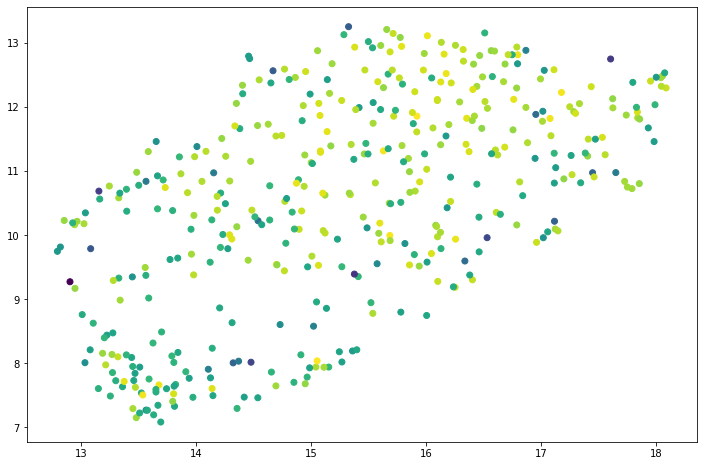

In [47]:
plt.figure(figsize=(12,8))
ax = plt.gca()
ax.scatter(latents_embedding[:,0], latents_embedding[:,1], c=evals_bz[all_cut].LL)
plt.show()

# Plot the vectors

In [48]:
low_idx = np.where(evals_bz[all_cut].LL < -100)[0]
high_idx = np.where(evals_bz[all_cut].LL > 150)[0]

In [36]:
median_low_latent = np.median(cut_latents[low_idx,:], axis=0)
median_low_latent.shape

(512,)

In [49]:
median_high_latent = np.median(cut_latents[high_idx,:], axis=0)

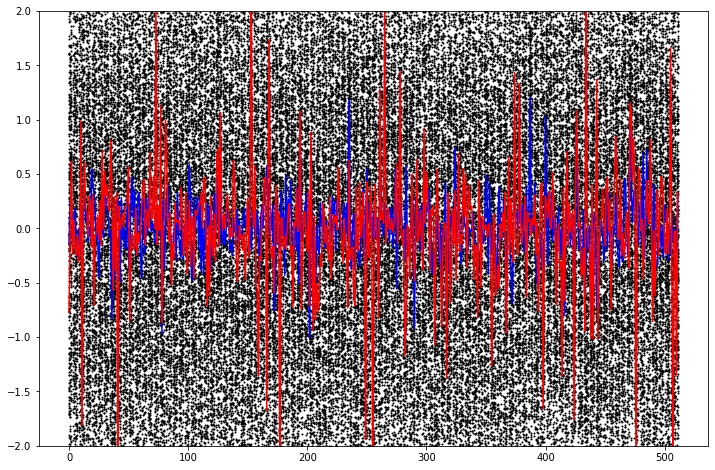

In [51]:
plt.figure(figsize=(12,8))
ax = plt.gca()
ax.plot(median_low_latent, color='b')
ax.plot(median_high_latent, color='r')
# Scatter the rest
for idx in low_idx:
    ax.scatter(np.arange(median_low_latent.size), cut_latents[idx, :], s=1, color='k')
#
ax.set_ylim(-2, 2.)
#ax.set_xlim(0,100)
#
plt.show()

# Dot product

## Normalize

In [55]:
norm_latent = np.linalg.norm(cut_latents[:].astype(float), axis=1)

In [57]:
norm_latents = cut_latents / np.outer(norm_latent, np.ones(512))

In [61]:
low_latents = norm_latents[low_idx,:]
high_latents = norm_latents[high_idx, :]

## Low with itself

In [62]:
low_dots = np.dot(low_latents, low_latents[0, :])

<AxesSubplot:ylabel='Count'>

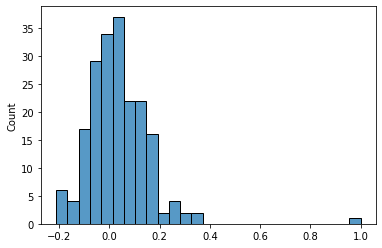

In [63]:
sns.histplot(low_dots)

## Low with High

In [64]:
lowhigh_dots = np.dot(high_latents, low_latents[0, :])

<AxesSubplot:ylabel='Count'>

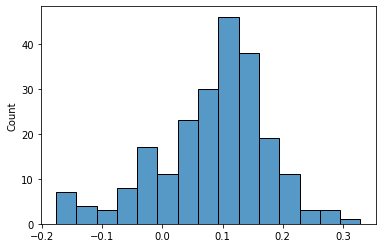

In [65]:
sns.histplot(lowhigh_dots)